In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=41ec830a79aaba0fa85c5be26bf6eaa6d1d4b9df86d1d07acc901eedfc5380e5
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

#from sklearn.metrics import accuracy_score roc_auc_score, classification_report, plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
#from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

import statsmodels.api as sm
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
# Drop unnecessary columns
train = train.drop('Unnamed: 0', axis=1)
train = train.drop('id', axis=1)
# Check size of the data set
#train.info()

# Drop unnecessary columns
test = test.drop('Unnamed: 0', axis=1)
test = test.drop('id', axis=1)
# Check size of the data set
#test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [ ]:
#Replace spaces in the column names with underscore - Train and Test
train.columns = [c.replace(' ', '_') for c in train.columns]
test.columns = [c.replace(' ', '_') for c in test.columns]

#Replacing label column "satisfaction" values with 0 and 1 (neutral or dissatisfied = 0 and satisfied = 1) - Train and Test
train['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
test['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

In [ ]:
# Imputing missing value with mean - Train and Test
train['Arrival_Delay_in_Minutes'] = train['Arrival_Delay_in_Minutes'].fillna(train['Arrival_Delay_in_Minutes'].mean())
test['Arrival_Delay_in_Minutes'] = test['Arrival_Delay_in_Minutes'].fillna(test['Arrival_Delay_in_Minutes'].mean())

In [ ]:
# Replace NaN with mode for categorical variables - Train and Test

train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])
train['Customer_Type'] = train['Customer_Type'].fillna(train['Customer_Type'].mode()[0])
train['Type_of_Travel'] = train['Type_of_Travel'].fillna(train['Type_of_Travel'].mode()[0])
train['Class'] = train['Class'].fillna(train['Class'].mode()[0])

test['Gender'] = test['Gender'].fillna(test['Gender'].mode()[0])
test['Customer_Type'] = test['Customer_Type'].fillna(test['Customer_Type'].mode()[0])
test['Type_of_Travel'] = test['Type_of_Travel'].fillna(test['Type_of_Travel'].mode()[0])
test['Class'] = test['Class'].fillna(test['Class'].mode()[0])

In [ ]:
# For Train set
lencoders = {}
for col in train.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    train[col] = lencoders[col].fit_transform(train[col])

    # For Test Set
lencoders_t = {}
for col in test.select_dtypes(include=['object']).columns:
    lencoders_t[col] = LabelEncoder()
    test[col] = lencoders_t[col].fit_transform(test[col])

In [ ]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Gender                                  1.0
Customer_Type                           0.0
Age                                    24.0
Type_of_Travel                          1.0
Class                                   1.0
Flight_Distance                      1329.0
Inflight_wifi_service                   2.0
Departure/Arrival_time_convenient       2.0
Ease_of_Online_booking                  2.0
Gate_location                           2.0
Food_and_drink                          2.0
Online_boarding                         2.0
Seat_comfort                            3.0
Inflight_entertainment                  2.0
On-board_service                        2.0
Leg_room_service                        2.0
Baggage_handling                        2.0
Checkin_service                         1.0
Inflight_service                        2.0
Cleanliness                             2.0
Departure_Delay_in_Minutes             12.0
Arrival_Delay_in_Minutes               13.0
satisfaction                    

In [ ]:
# Removal of outliers from dataset
train = train[~((train < (Q1 - 1.5 * IQR)) |(train > (Q3 + 1.5 * IQR))).any(axis=1)]
train.shape

(61197, 23)

In [ ]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(train)
modified_data = pd.DataFrame(r_scaler.transform(train), columns=train.columns)
modified_data.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1.0,0.0,0.076923,1.0,1.0,0.115789,0.6,0.8,0.6,0.2,...,1.0,0.8,0.6,0.75,0.666667,1.0,1.0,0.833333,0.56250,0.0
1,0.0,0.0,0.243590,0.0,0.0,0.299865,0.4,0.4,0.4,0.4,...,1.0,0.8,0.6,0.75,0.666667,0.8,1.0,0.000000,0.00000,1.0
2,1.0,0.0,0.692308,0.0,0.0,0.049393,0.6,0.6,0.6,0.6,...,0.6,0.6,0.8,0.75,0.333333,0.6,0.6,0.000000,0.00000,1.0
3,0.0,0.0,0.243590,1.0,0.5,0.310121,0.6,0.8,0.4,0.2,...,0.2,0.6,0.8,0.75,0.666667,0.8,0.2,0.000000,0.00000,0.0
4,1.0,0.0,0.512821,1.0,0.5,0.336032,0.4,0.8,0.4,0.6,...,0.4,0.6,0.6,0.75,0.333333,1.0,0.4,0.300000,0.71875,0.0


In [ ]:
X = modified_data.loc[:,modified_data.columns!='satisfaction']
y = modified_data[['satisfaction']]
selector = SelectKBest(chi2, k=12)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Type_of_Travel', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Online_boarding', 'Seat_comfort', 'Inflight_entertainment',
       'On-board_service', 'Leg_room_service', 'Baggage_handling',
       'Checkin_service', 'Cleanliness'],
      dtype='object')


In [ ]:
X = train.drop('satisfaction', axis=1)
y = train['satisfaction']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Type_of_Travel', 'Class', 'Inflight_wifi_service', 'Online_boarding', 'Seat_comfort', 'Inflight_entertainment']
[0.00412513 0.         0.0258749  0.21982853 0.08990315 0.03140161
 0.12224491 0.01737014 0.03081474 0.01485982 0.01068989 0.11324523
 0.06338185 0.06652081 0.02798984 0.04231821 0.02388634 0.02276466
 0.02411625 0.03309566 0.00702376 0.00854455]


In [ ]:
perm = PermutationImportance(rf(n_estimators=100, random_state=0).fit(X,y),random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.2723 ± 0.0039,Type_of_Travel
0.1278 ± 0.0026,Inflight_wifi_service
0.0435 ± 0.0011,Online_boarding
0.0424 ± 0.0013,Seat_comfort
0.0355 ± 0.0009,Checkin_service
0.0294 ± 0.0014,Inflight_service
0.0289 ± 0.0008,Baggage_handling
0.0246 ± 0.0006,Cleanliness
0.0177 ± 0.0007,On-board_service
0.0172 ± 0.0007,Class


In [ ]:
features = ['Type_of_Travel','Inflight_wifi_service','Online_boarding','Seat_comfort','Flight_Distance',
            'Inflight_entertainment','On-board_service','Leg_room_service','Cleanliness','Checkin_service',
            'Inflight_service', 'Baggage_handling','Class']
target = ['satisfaction']

# Split into test and train
X_train = train[features]
y_train = train[target].to_numpy()
X_test = test[features]
y_test = test[target].to_numpy()

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

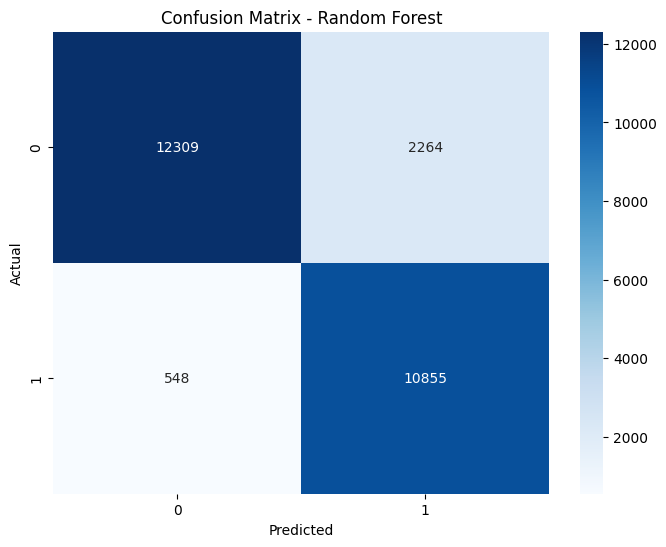

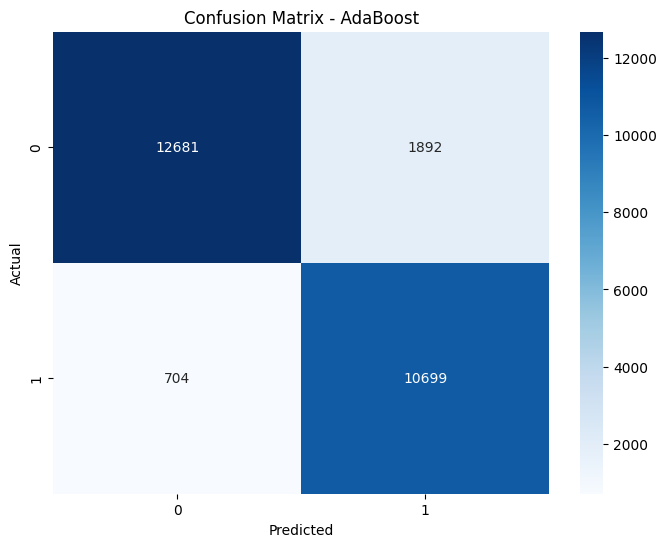

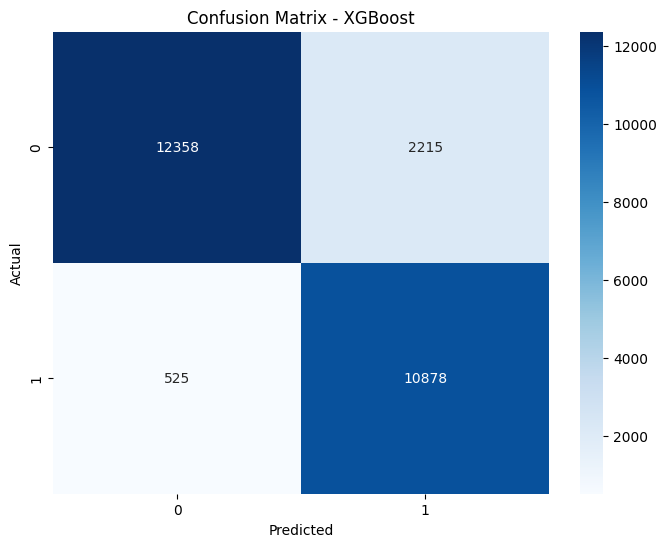

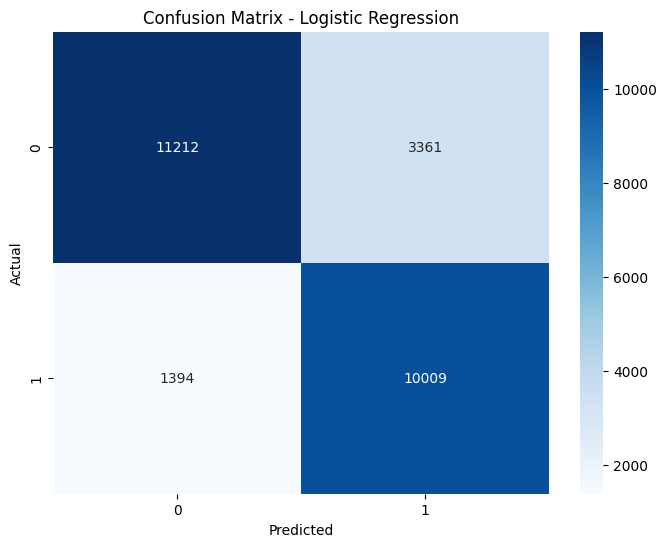

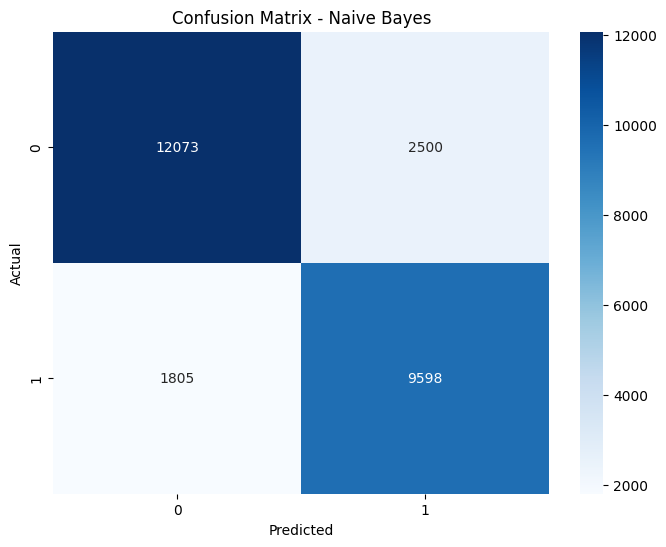

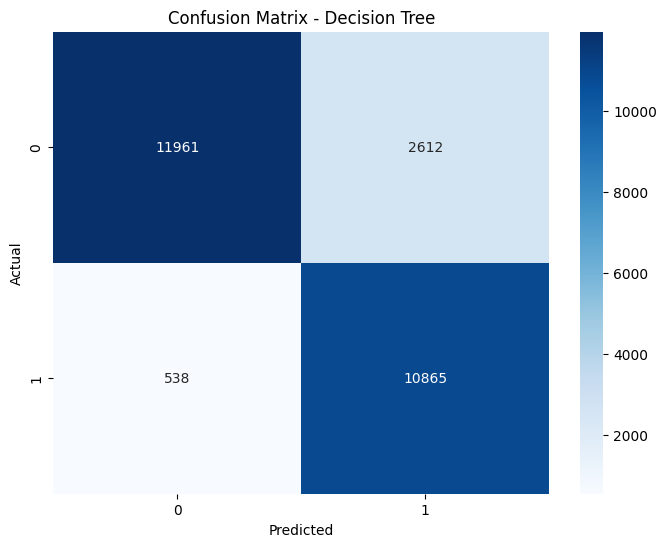

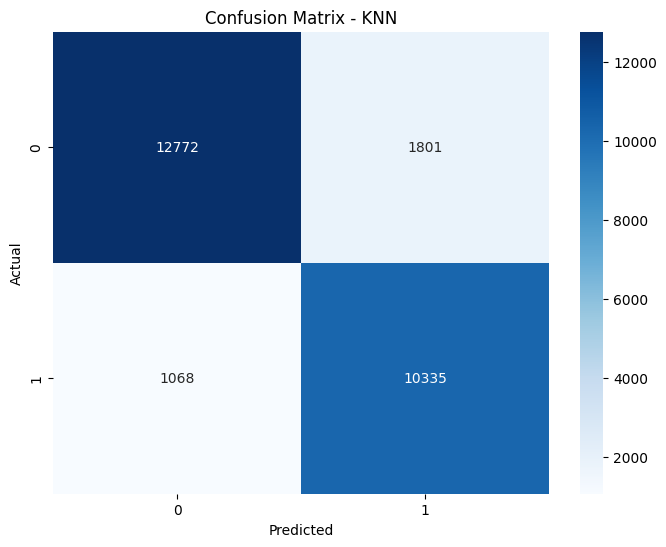

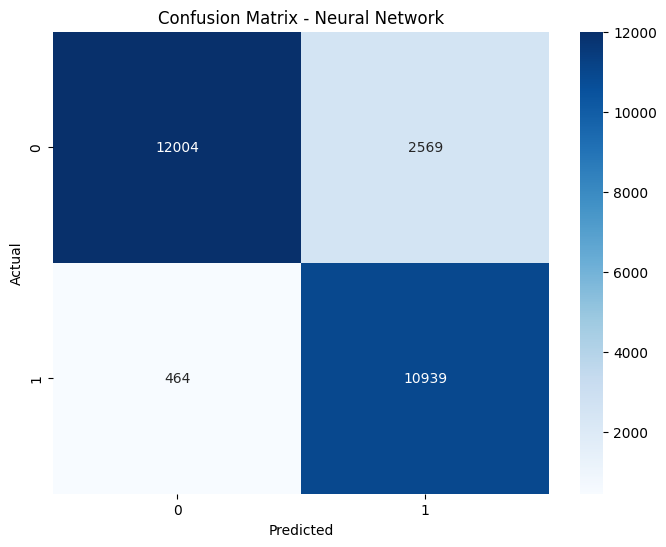

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time

classifiers = {
    'Random Forest': RandomForestClassifier(max_depth=16, min_samples_leaf=1,
                                          min_samples_split=2, n_estimators=100, random_state=12345),
    'AdaBoost': AdaBoostClassifier(n_estimators=500, random_state=12345),
    'XGBoost': xgb.XGBClassifier(n_estimators=500, max_depth=16, random_state=42),

    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=12, max_features="sqrt"),
    'KNN': KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree', n_jobs=4),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(30, 30, 30), activation='logistic', solver='lbfgs', max_iter=100)
}


for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(X_train, y_train)
    time_taken = time.time() - start_time

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, digits=5)
    confusion_mtx = confusion_matrix(y_test, y_pred)

results = {}

for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(X_train, y_train)
    time_taken = time.time() - start_time

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, digits=5)
    confusion_mtx = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Classification Report': classification_rep,
        'Confusion Matrix': confusion_mtx,
        'Time taken': time_taken
    }


# Visualize confusion matrix
for name, metrics in results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



In [ ]:
# Print results
for name, metrics in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1-score: {metrics['F1-score']}")
    print(f"Time taken: {metrics['Time taken']} seconds")
    print(f"Classification Report:\n{metrics['Classification Report']}\n")

Classifier: Random Forest
Accuracy: 0.8917462272867263
ROC AUC: 0.8982933381580998
Precision: 0.8274258708743044
Recall: 0.9519424712794878
F1-score: 0.8853274610553789
Time taken: 5.888281583786011 seconds
Classification Report:
              precision    recall  f1-score   support

           0    0.95738   0.84464   0.89748     14573
           1    0.82743   0.95194   0.88533     11403

    accuracy                        0.89175     25976
   macro avg    0.89240   0.89829   0.89141     25976
weighted avg    0.90033   0.89175   0.89215     25976


Classifier: AdaBoost
Accuracy: 0.9000615953187557
ROC AUC: 0.9042163624201169
Precision: 0.8497339369390835
Recall: 0.9382618609137946
F1-score: 0.8918062849045596
Time taken: 3.750936269760132 seconds
Classification Report:
              precision    recall  f1-score   support

           0    0.94740   0.87017   0.90715     14573
           1    0.84973   0.93826   0.89181     11403

    accuracy                        0.90006     25976

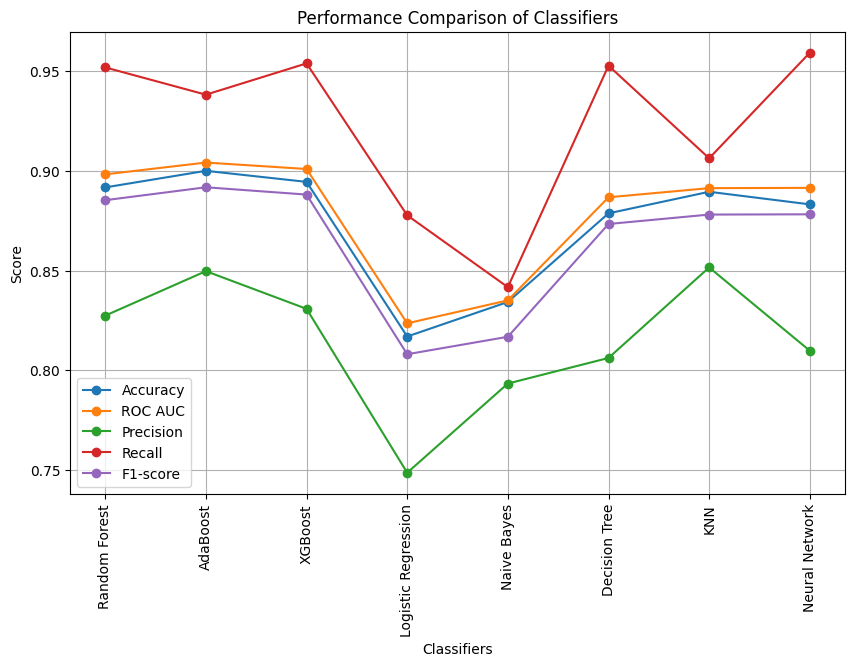

In [ ]:
# Plot results
metrics = ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1-score']
plt.figure(figsize=(10, 6))

for metric in metrics:
    scores = [results[name][metric] for name in classifiers.keys()]
    plt.plot(classifiers.keys(), scores, marker='o', label=metric)

plt.title('Performance Comparison of Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation='vertical')
plt.grid(True)
plt.show()

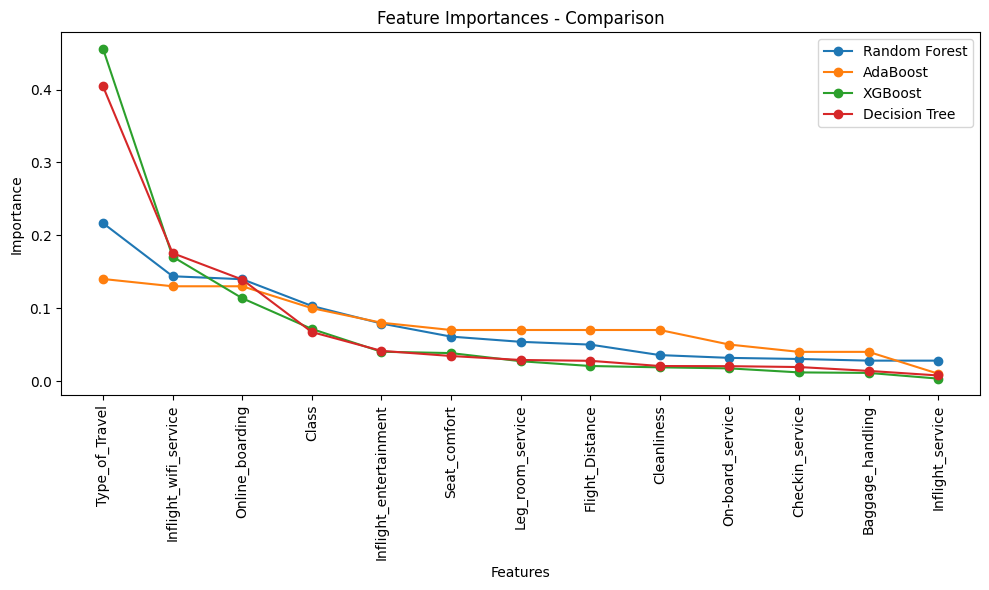

In [ ]:
# Calculate feature importances for each classifier
importances_rf = classifiers['Random Forest'].feature_importances_
importances_ab = np.mean([tree.feature_importances_ for tree in classifiers['AdaBoost'].estimators_], axis=0)
importances_xgb = classifiers['XGBoost'].feature_importances_
#importances_lr = np.abs(classifiers['Logistic Regression'].coef_[0])
importances_dt = classifiers['Decision Tree'].feature_importances_

# Sort indices for each classifier
indices_rf = np.argsort(importances_rf)[::-1]
indices_ab = np.argsort(importances_ab)[::-1]
indices_xgb = np.argsort(importances_xgb)[::-1]
#indices_lr = np.argsort(importances_lr)[::-1]
indices_dt = np.argsort(importances_dt)[::-1]

# Set up the figure and axis
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Comparison")
plt.ylabel("Importance")
plt.xlabel("Features")

# Plot feature importances for each classifier
plt.plot(range(len(features)), importances_rf[indices_rf], marker="o", label="Random Forest")
plt.plot(range(len(features)), importances_ab[indices_ab], marker="o", label="AdaBoost")
plt.plot(range(len(features)), importances_xgb[indices_xgb], marker="o", label="XGBoost")
#plt.plot(range(len(features)), importances_lr[indices_lr], marker="o", label="Logistic Regression")
plt.plot(range(len(features)), importances_dt[indices_dt], marker="o", label="Decision Tree")

# Set x-axis tick labels
plt.xticks(range(len(features)), [features[i] for i in indices_rf], rotation=90)

# Add a legend
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Print feature importances for each classifier
print("Random Forest Feature Importances:")
for index in indices_rf:
    print(f"{features[index]}: {importances_rf[index]}")

print("\nAdaBoost Feature Importances:")
for index in indices_ab:
    print(f"{features[index]}: {importances_ab[index]}")

print("\nXGBoost Feature Importances:")
for index in indices_xgb:
    print(f"{features[index]}: {importances_xgb[index]}")

print("\nDecision Tree Feature Importances:")
for index in indices_dt:
    print(f"{features[index]}: {importances_dt[index]}")


Random Forest Feature Importances:
Type_of_Travel: 0.21659262218426648
Inflight_wifi_service: 0.14373727036261597
Online_boarding: 0.139687445676301
Class: 0.1029844275561045
Inflight_entertainment: 0.07887985300286862
Seat_comfort: 0.06093424216403734
Leg_room_service: 0.053782777138279024
Flight_Distance: 0.049951023843086174
Cleanliness: 0.03555860430077321
On-board_service: 0.03174671276891308
Checkin_service: 0.03023738490123953
Baggage_handling: 0.027962985949186833
Inflight_service: 0.027944650152328363

AdaBoost Feature Importances:
Inflight_entertainment: 0.14
Seat_comfort: 0.13
Inflight_wifi_service: 0.13
On-board_service: 0.1
Inflight_service: 0.08
Baggage_handling: 0.07
Leg_room_service: 0.07
Flight_Distance: 0.07
Online_boarding: 0.07
Type_of_Travel: 0.05
Checkin_service: 0.04
Cleanliness: 0.04
Class: 0.01

XGBoost Feature Importances:
Type_of_Travel: 0.45584335923194885
Inflight_entertainment: 0.17058424651622772
Inflight_wifi_service: 0.11361326277256012
Online_boarding: